# Analysis of the screening results
---

This notebook evaluates the results of the specificity screen. For the screen we trained an Ensemble of two Resnet18 pretrained on the Imagenet data set that processed the individual single-nuclei images as well as whole FoV images. The latter model can use the whole FoV images to also derive distributional information like e.g. the cell density that might be helpful to distinguish the negative control setting from the OE condition. Note that while the illumination has been corrected for there might still be related artifacts that the model potential could overfit on.

First, single nuclei and FoV images are scaled by subtracting the 0.1 percentile and dividing the image by the 99.9 percentile to make the images comparable and limit the influence of oversaturated artifacts. The images are clipped such that the values are within 0,1 respectively 0, 255 after rescaling the images to 8-bit integer range.

We augmented the single nuclei images by resizing them from 96x96 to 224x224 and randomly flipping them horizontally and vertically before forming pseudo-RGB images and normalizing those using the mean and standard deviations of the ImageNet data set. 

Additionally for each nuclei we obtained the corresponding FoV image by cropping the 1080x1080 centered around the nuclei for a patch size of 448x448. If required the FoV image is padded with the lower percentile value before. The crops are then also randomly flipped during training, transformed into pseudo-RGBs and normalized.


In this notebook, we will first compare the model with the results of a similar screen run only on the single-nuclei images processed as described above by a pretrained ResNet18 model. Second, we will compare the results of such screen using the morphological embeddings computed by the authors of the original publication. Third, using a automatic approach we will identify a subset of OE conditions that yield to a reproducible and specific structural phenotype in the cell populations different from the negative controls by thresholding a defined specificity score.
The final evaluation of the selected set of OE condition targets will conclude this analysis.

## 0. Environmental setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import venn
from typing import List
from umap import UMAP
import os
from scipy.stats import pearsonr
from kneed import KneeLocator
from loess import loess_1d
from scipy.stats import fisher_exact, ranksums
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from statannot import add_stat_annotation

import sys

sys.path.append("../../..")

from src.utils.basic.io import get_file_list
from src.utils.notebooks.images.exp_evaluation import *

mpl.rcParams["figure.dpi"] = 600

%autosave 60

2024-10-24 15:56:35.817920: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Autosaving every 60 seconds


---

## 1. Read in data

In [39]:
screen_results_fold_0 = analyze_screen_results(
    "/data/xinyi/image2reg/data_new/experiments/jump/images/screen/nuclei_region/fold_0",testonly=True
)
screen_results_fold_1 = analyze_screen_results(
    "/data/xinyi/image2reg/data_new/experiments/jump/images/screen/nuclei_region/fold_1",testonly=True
)
screen_results_fold_2 = analyze_screen_results(
    "/data/xinyi/image2reg/data_new/experiments/jump/images/screen/nuclei_region/fold_2",testonly=True
)
screen_results_fold_3 = analyze_screen_results(
    "/data/xinyi/image2reg/data_new/experiments/jump/images/screen/nuclei_region/fold_3",testonly=True
)
screen_results_fold_4 = analyze_screen_results(
    "/data/xinyi/image2reg/data_new/experiments/jump/images/screen/nuclei_region/fold_4",testonly=True
)

(array([ 2.,  5.,  9., 11., 24., 21., 23., 16., 19., 14.]),
 array([0.42304104, 0.48029526, 0.53754948, 0.5948037 , 0.65205792,
        0.70931214, 0.76656635, 0.82382057, 0.88107479, 0.93832901,
        0.99558323]),
 <BarContainer object of 10 artists>)

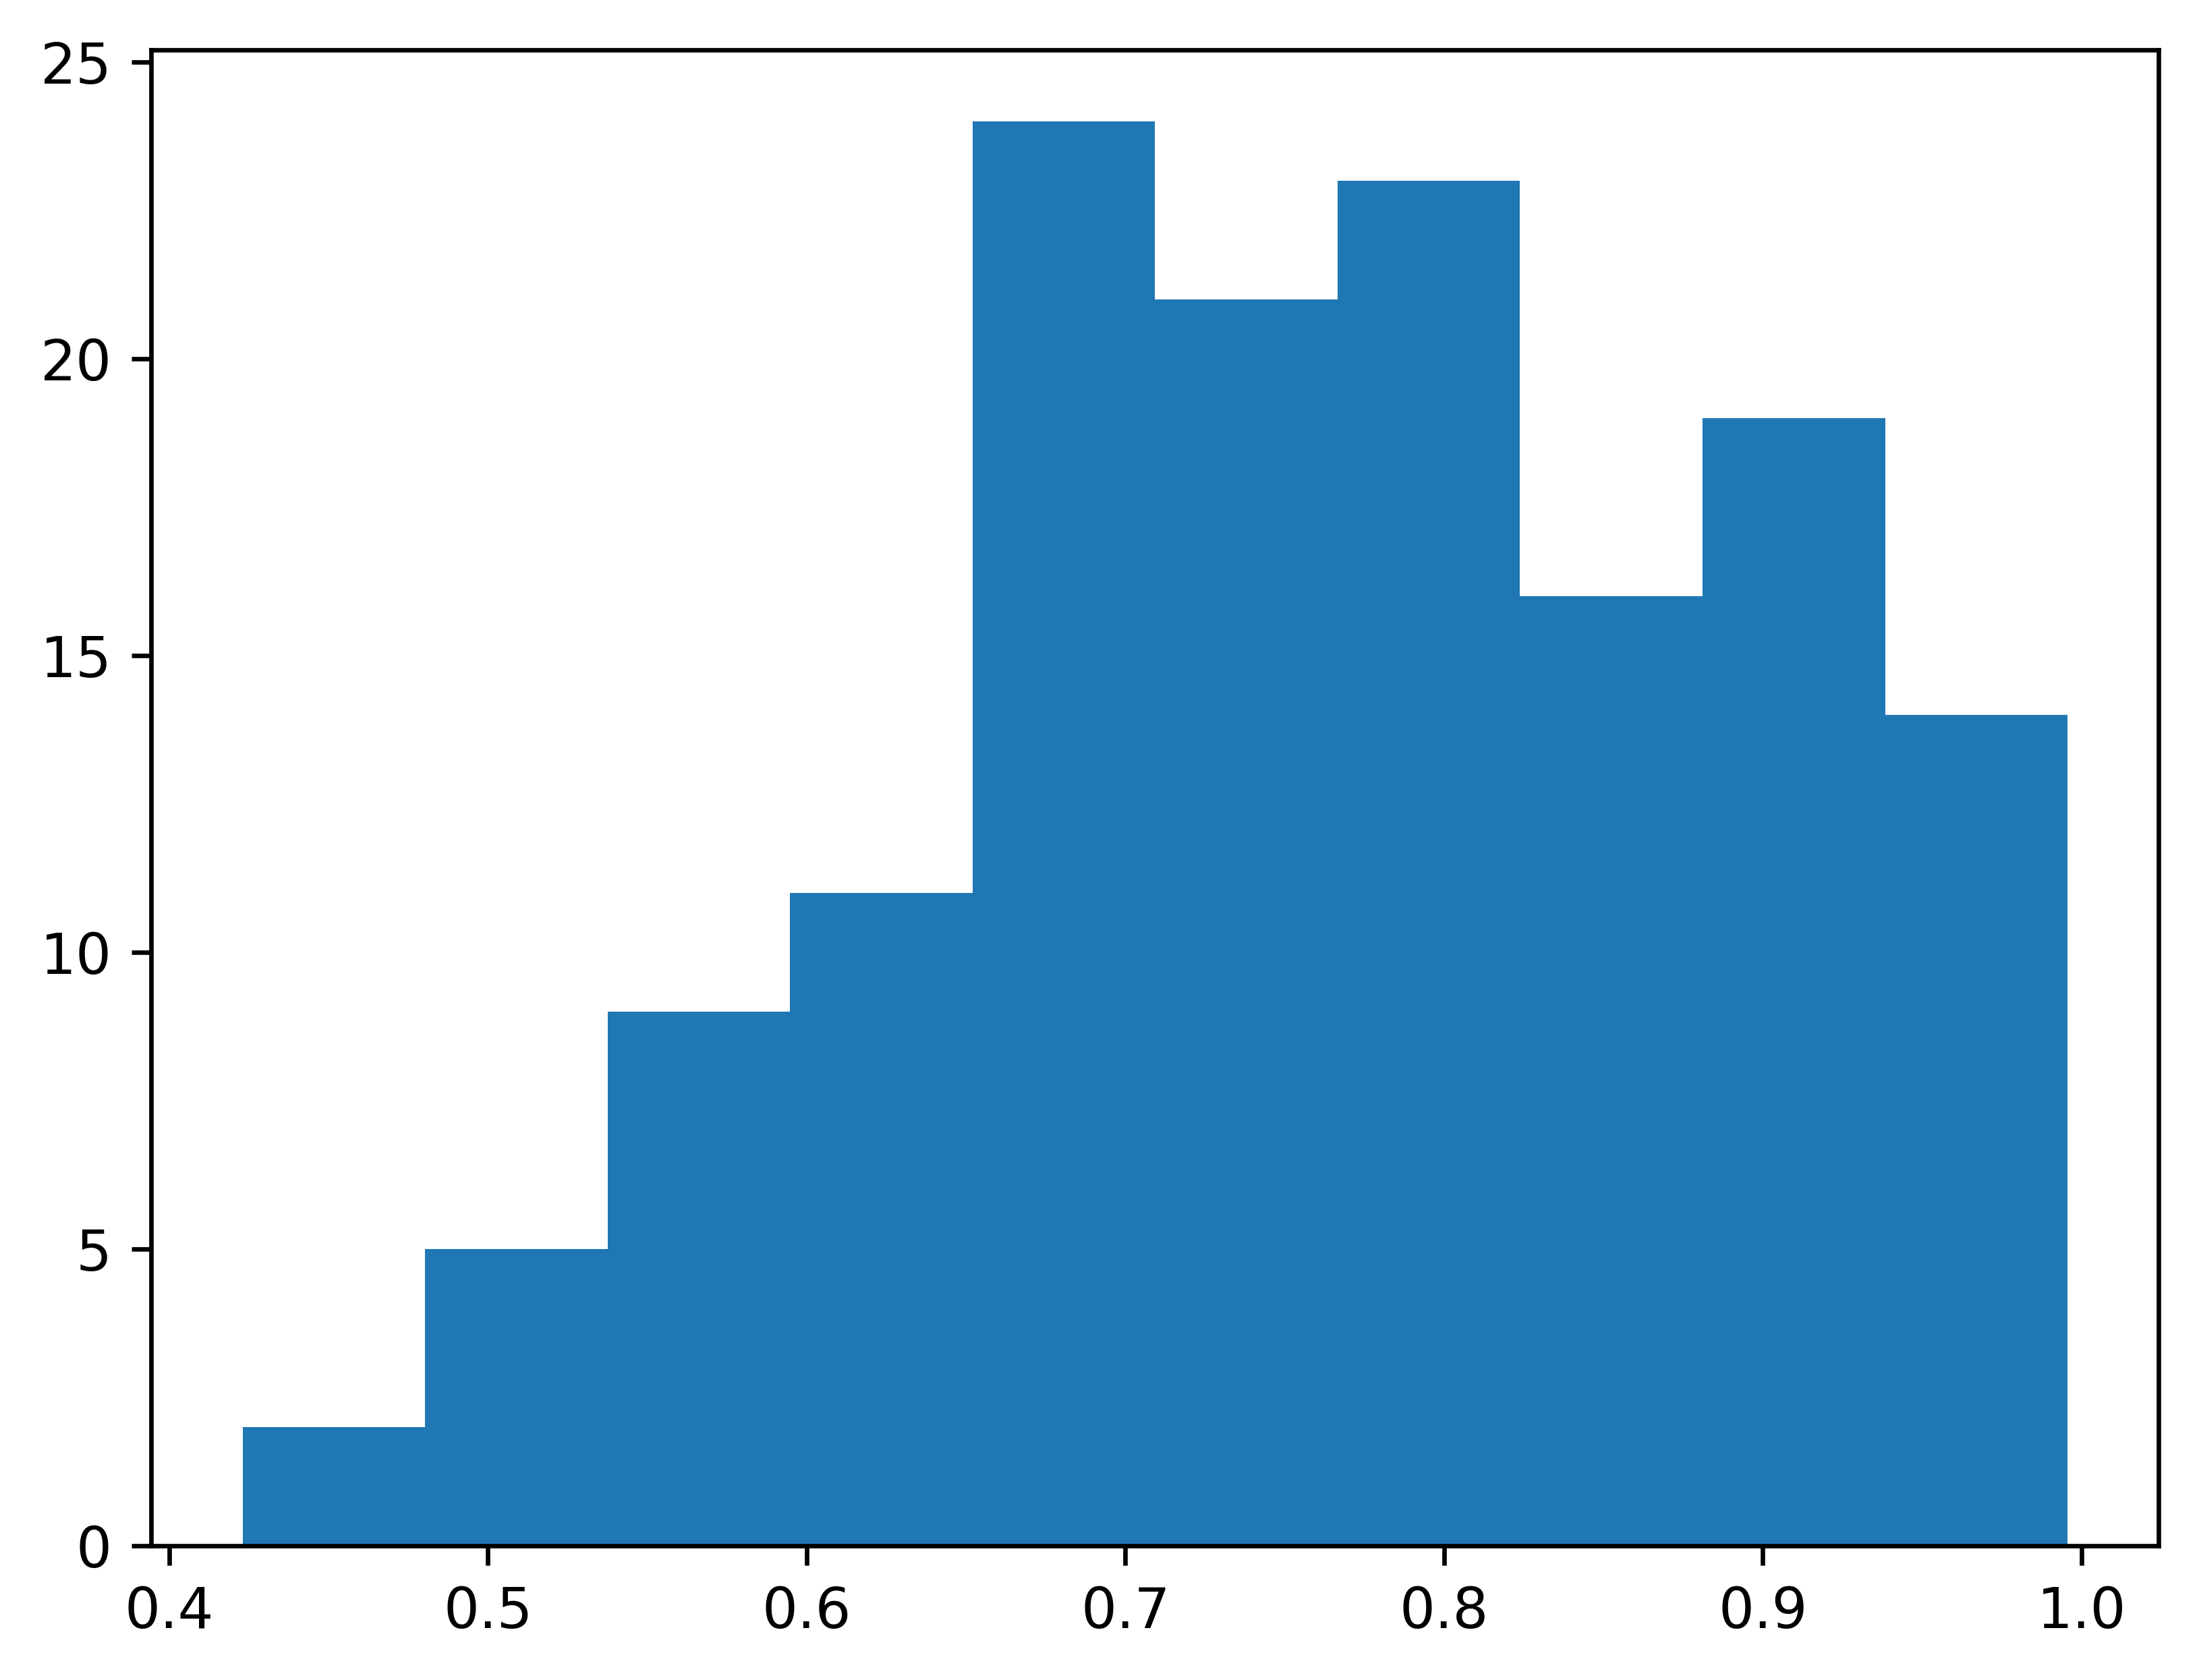

In [9]:
plt.hist(screen_results_fold_0.test_bacc)

In [40]:
screen_results = pd.concat([screen_results_fold_0,screen_results_fold_1,screen_results_fold_2,screen_results_fold_3,screen_results_fold_4])

In [41]:
screen_results

,target,test_loss,test_acc,test_bacc
0,ALOX5,0.744666,0.765283,0.766423
1,AQP1,0.963161,0.604357,0.604643
2,ATF4,0.280535,0.886574,0.886492
3,AURKA,0.074975,0.967105,0.966886
4,AURKB,0.079483,0.970395,0.970351
...,...,...,...,...
142,UCHL5,1.065505,0.548920,0.548160
143,WEE1,0.058286,0.981618,0.981852
144,WWTR1,0.705136,0.686479,0.685805
145,YES1,0.724165,0.661284,0.661207


---

## 2. Analyses

### 2.1. Exploratory analyses

After having read in the data, we will first compute specificity score for each target which is given by the mean cross-validated balanced accuracy for each target. We will plot the corresponding scores in decreasing order as a dot-plot with error bars indicating the standard deviation for each target.

In [42]:
order = list(
    screen_results.groupby("target")
    .mean()
    .sort_values("test_bacc", ascending=False)
    .index
)

In [43]:
screen_results.loc[screen_results.target.isin(order)].shape

(733, 4)

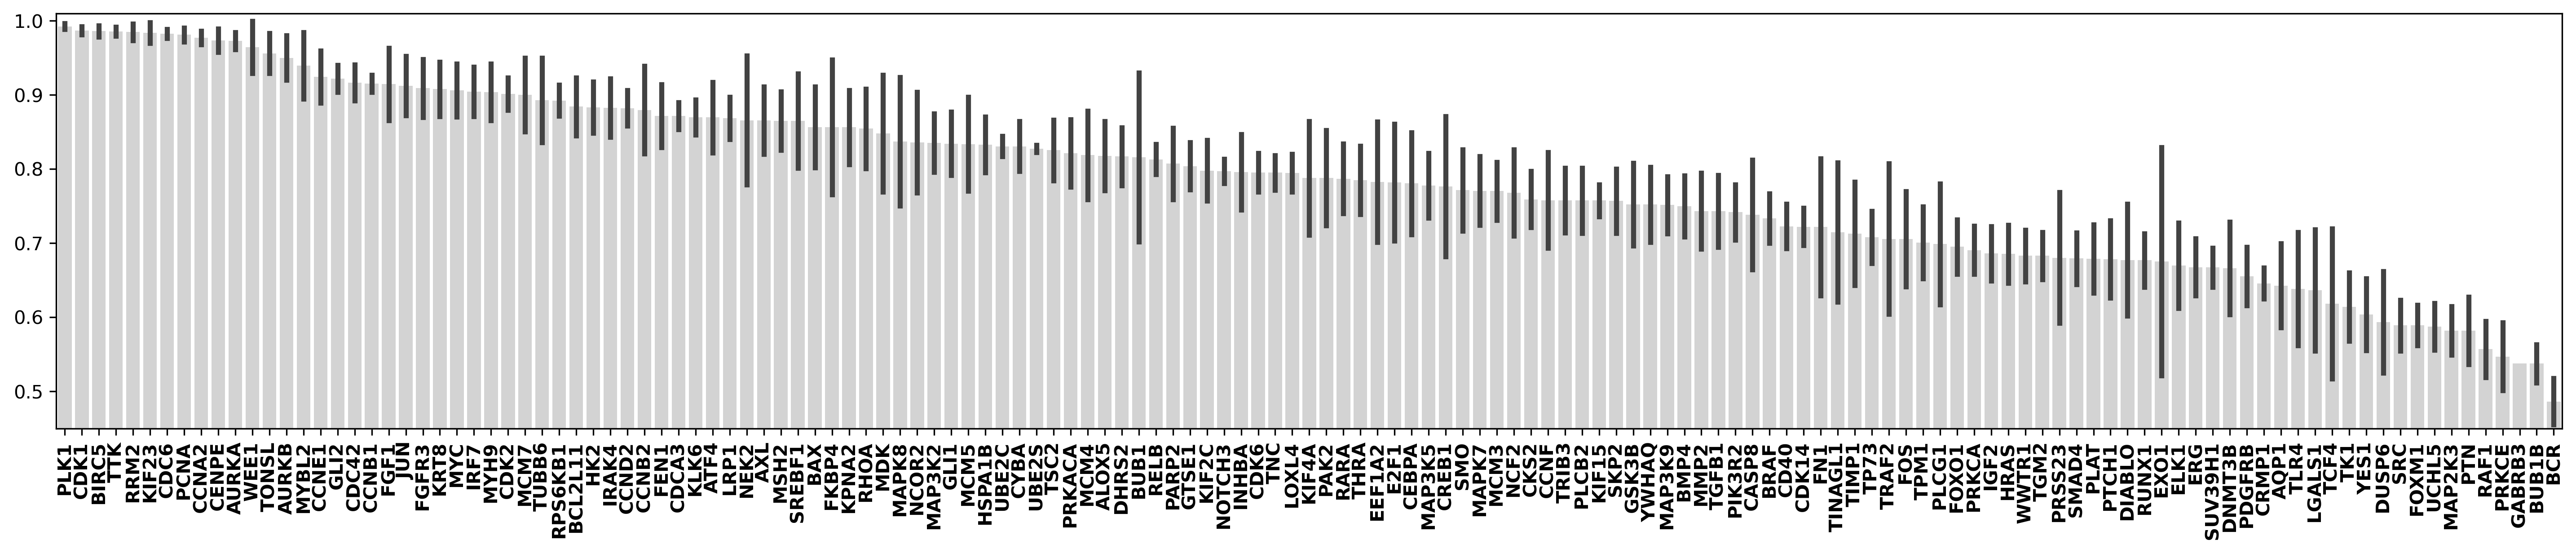

In [44]:
fig, ax = plt.subplots(figsize=[24, 4])
ax = sns.barplot(
    data=screen_results.loc[screen_results.target.isin(order)],
    x="target",
    y="test_bacc",
    errorbar='sd',
    order=order,
    color="lightgray",
    ax=ax,
)
ax.set_ylim([0.45, 1.01])
ax.set_xticklabels(order, rotation=90, fontsize=10, fontweight="bold")
ax.set_ylabel("")
ax.set_xlabel("")
plt.show()

---

## 3. Validation of the specificity scores

Before we proceed further, we aim to validate our definition of the specifity score. To this end, we will look at the distribution of the respective score (from now on focussing on the multi-image input model-based screen) in different gene sets, i.e. one that describes the 76 genes that were identified as yielding specific and reproducible structural phenotypes upon overexpression of corresponding alleles in the study by Rohban et al. (2017) as well as a set obtained from the curation of multiple pathways that are expected to modulate the chromatin organization and cellular morphology.

In [45]:
mean_spec_results = screen_results.groupby("target").mean()
mean_spec_results["mean_balanced_accuracy"] = mean_spec_results.test_bacc

In [46]:
sorted(np.array(mean_spec_results.test_bacc))[-41]

0.865777312

As seen above the CV-balanced accuracy is significantly higher in both gene sets as expected.

---

## 4. Identifying specific ORF targets

Next, we will select a cut-off for the specificity score to identify a subset of ORF targets that yield a specific and reproducible structural phenotype upon overexpression. To this end, we will use the elbow method. We will first compute identify a cut-off for the specificty score given by the average balanced accuracy of our four-fold crossvalidation using the kneedle algorithm using the recommened default parameters as described in Satopaa et al. (2011).

### 4.1. Target identification

In [47]:
idx = np.arange(len(mean_spec_results))
sorted_mean_bacs = np.array(
    mean_spec_results.sort_values("test_bacc", ascending=False).test_bacc
)

In [48]:
kneedle = KneeLocator(
    idx,
    sorted_mean_bacs,
    curve="convex",
    online=False,
    direction="decreasing",
    S=2,
)

In [49]:
print(
    "Elbow found at: idx={}, spec_score={} ".format(
        kneedle.knee, sorted_mean_bacs[kneedle.knee]
    ),
)

Elbow found at: idx=1, spec_score=0.986637398 


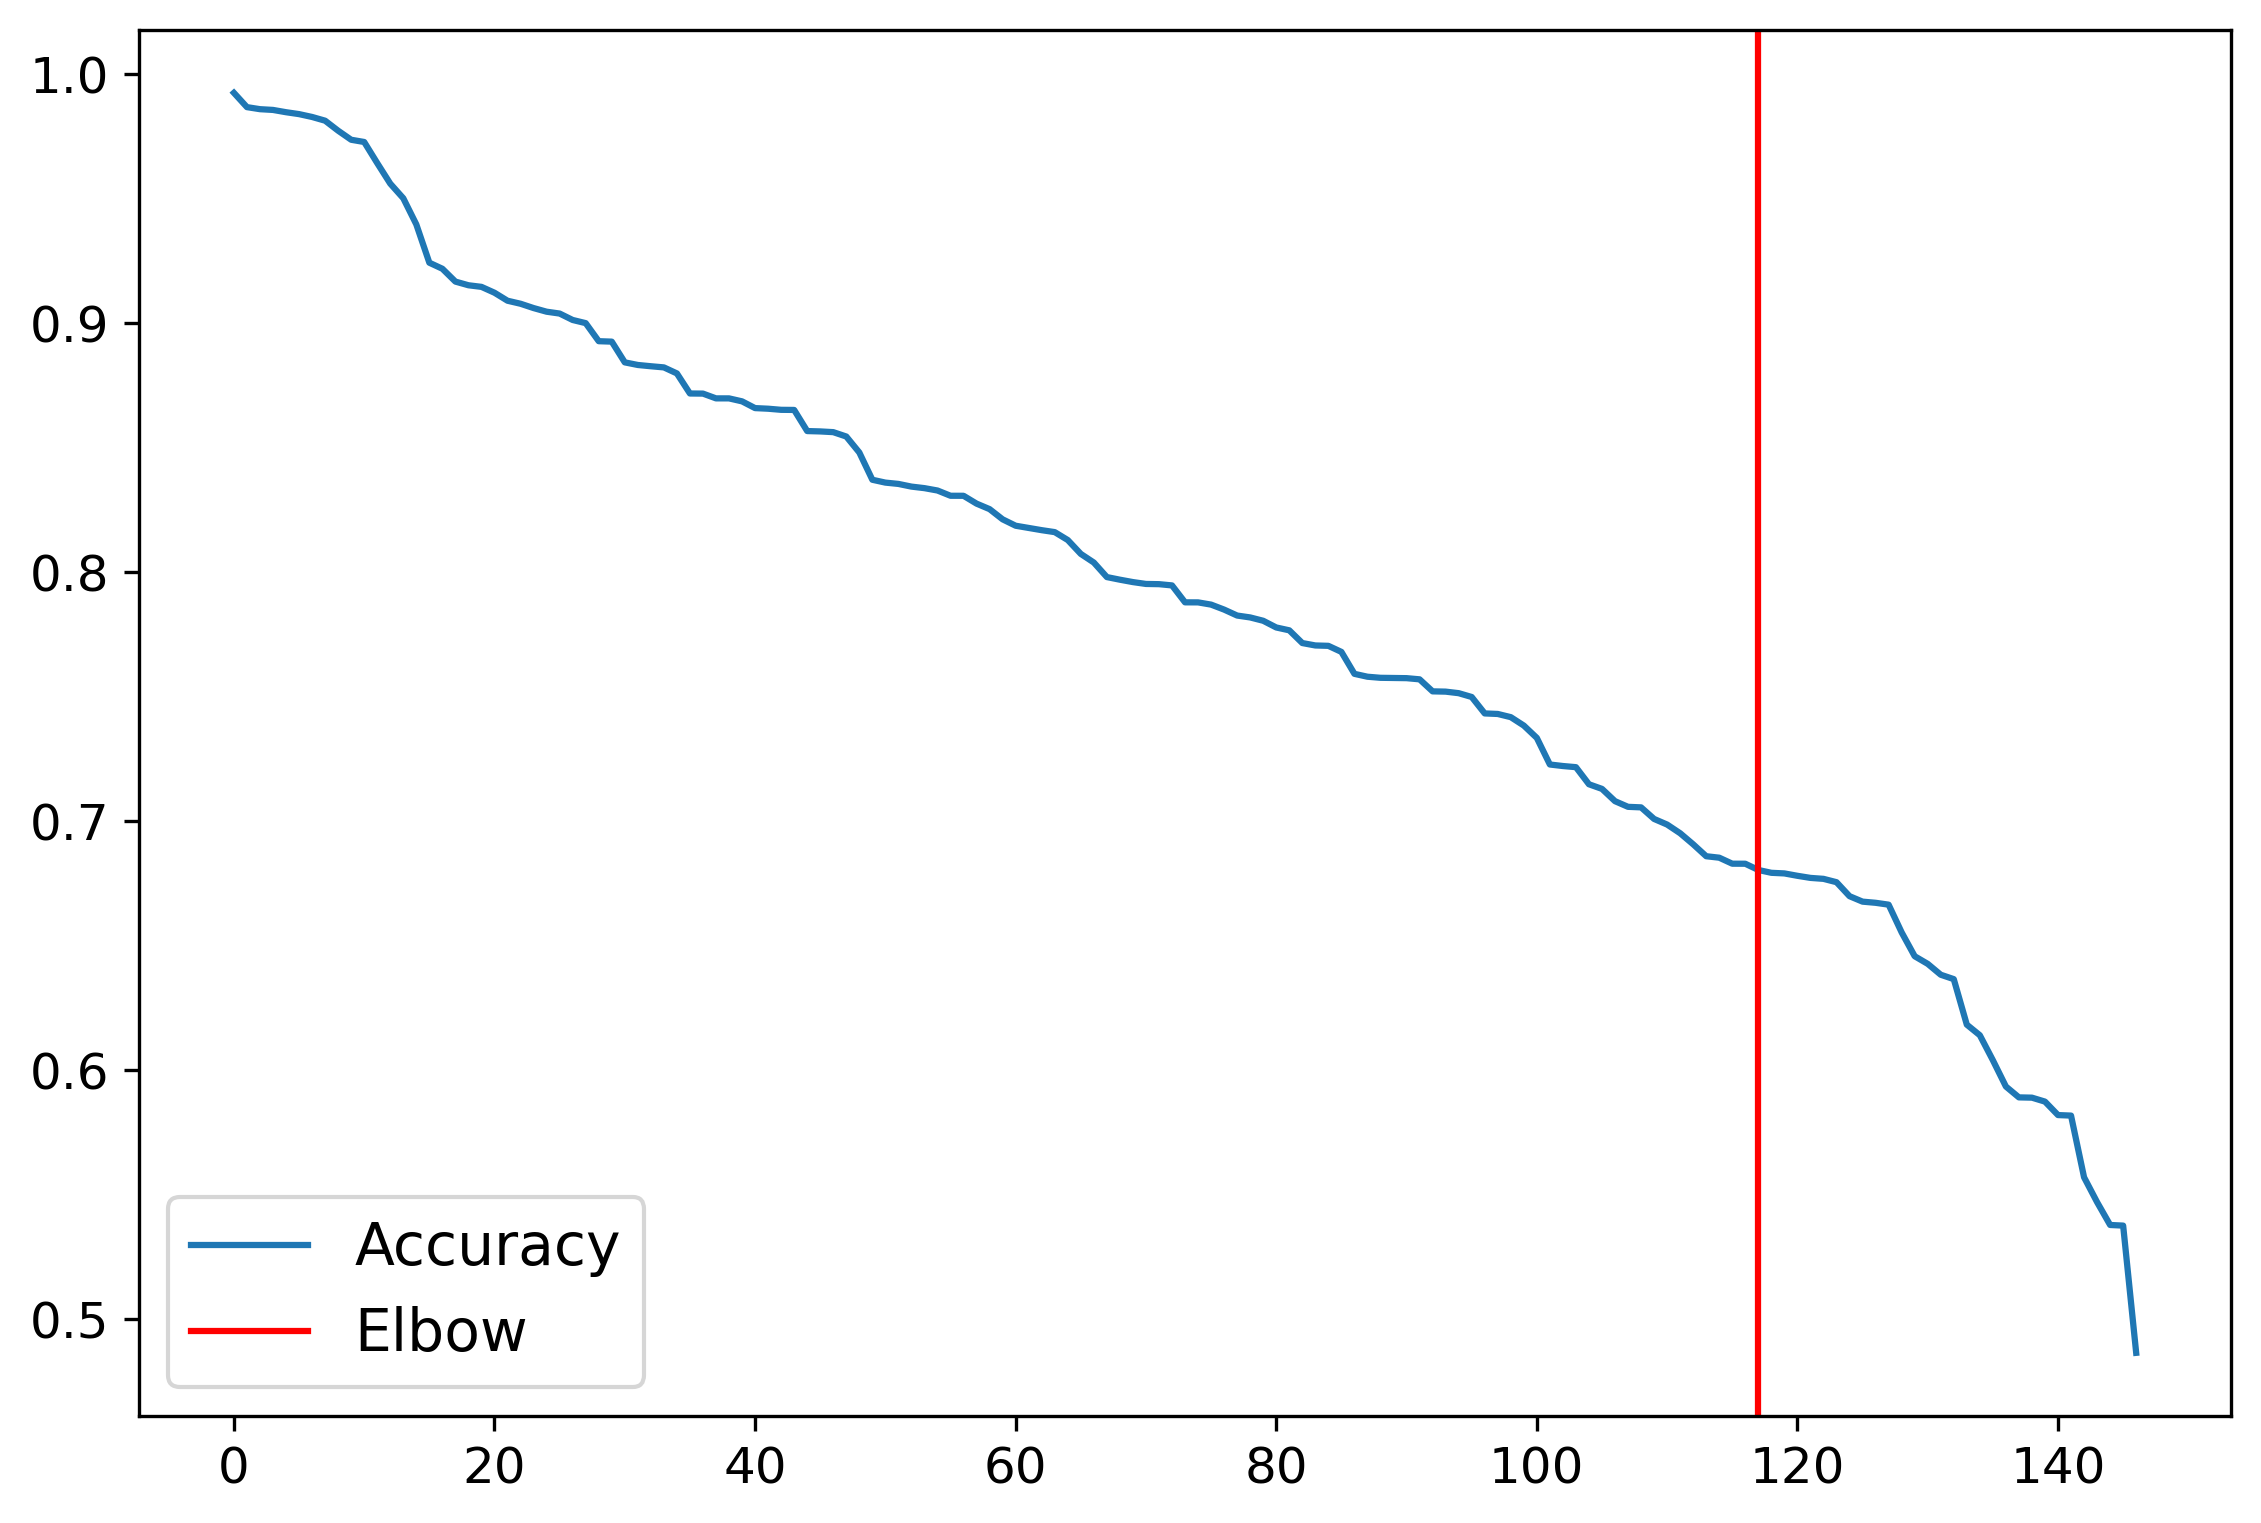

In [78]:
fig, ax = plt.subplots(figsize=[9, 6])
ax.plot(
    idx,
    sorted_mean_bacs,
    label="Accuracy",
)
# ax.set_ylabel("Mean CV-balanced accuracy")
# ax.set_title("Mean CV-balanced accuracy of the ORF targets")
ax.axvline(x=117, c="r", label="Elbow")
plt.legend(prop=dict(size=14))
ax.tick_params(axis="both", which="major", labelsize=12)
# ax.set_ylabel("Specificity score")
# ax.set_xlabel("Index")
# ax.set_title("Identification of the specificity threshold")
plt.show()

The algorithm identifies the knee of the curve at the index 45 correspodning to a specificty score of 0.6648.
However, this does not take into account the variability of the computed test balanced accuracy. As seen below there is a small step prior to the selected cut-off at a specificty score of 0.6802 corresponding to target PRKCE. Since the next best target of FGFR3 shows very little standard deviation, we decide to include that sample and set the cut-off such that we include the 41 targets with the highest cross-validated balanced accuracy score ( > 0.6705).

In [28]:
order = list(
    screen_results.groupby("target")
    .mean()
    .sort_values("test_bacc", ascending=False)
    .index
)

In [68]:
IGthresh=0.682
nIGenes=np.sum(mean_spec_results.test_bacc>IGthresh)

In [69]:
nIGenes

117

/tmp/ipykernel_2854924/569640300.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(


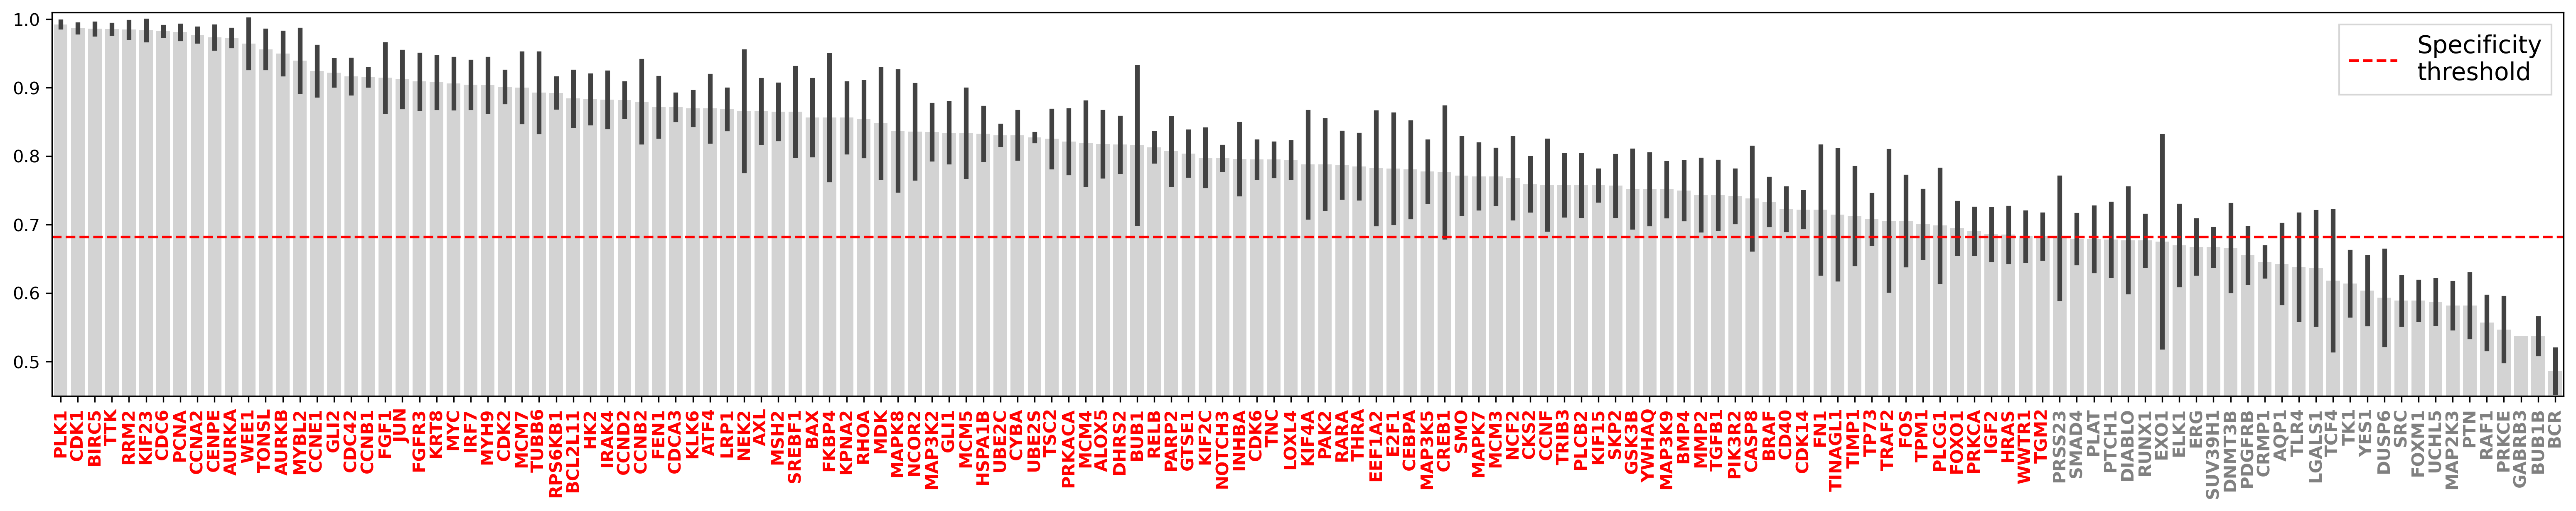

In [70]:
mpl.rcParams["figure.dpi"] = 300
fig, ax = plt.subplots(figsize=[26, 4])
ax = sns.barplot(
    data=screen_results.loc[screen_results.target.isin(order)],
    x="target",
    y="test_bacc",
    ci="sd",
    order=order,
    color="lightgray",
    ax=ax,
)
ax.set_ylim([0.45, 1.01])
ax.set_xticklabels(order, rotation=90, fontsize=10, fontweight="bold")
i = 0
for t in ax.xaxis.get_ticklabels():
    if i < nIGenes:
        t.set_color("red")
    #     elif i < 45:
    #         t.set_color("gray")
    else:
        t.set_color("gray")
    i += 1
ax.axhline(
    y=IGthresh, linestyle="dashed", c="r", label="Specificity\nthreshold"
)
ax.legend(prop=dict(size=14), fancybox=False)
ax.set_ylabel("")
ax.set_xlabel("")
plt.show()

/tmp/ipykernel_2854924/2746203896.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(


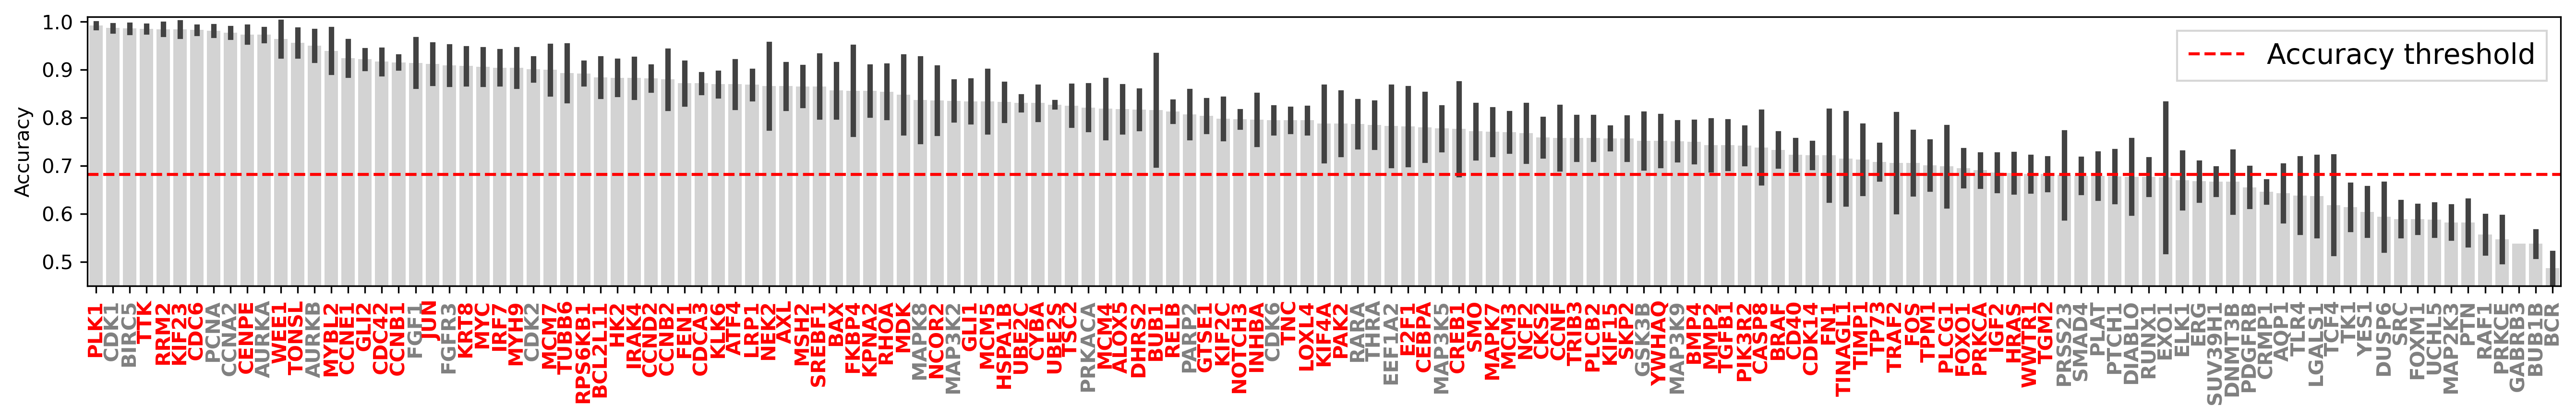

In [90]:
compoundgenes=np.array(['APPBP2', 'AQP1', 'AURKA', 'AURKB', 'BIRC5', 'CCNA2', 'CDK1',
                        'CDK2', 'CDK6', 'DMSO', 'EEF1A2', 'FGF1', 'FGFR2', 'FGFR3',
                        'GABRB3', 'GSK3B', 'LGALS1', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MAPK8',
                        'PARP2', 'PCNA', 'PDGFRB', 'PLAT', 'PRKACA', 'RARA', 'THRA', 'TK1',
                        'TLR4', 'TNNC1'])
mpl.rcParams["figure.dpi"] = 300
fig, ax = plt.subplots(figsize=[18, 3])
ax = sns.barplot(
    data=screen_results.loc[screen_results.target.isin(order)],
    x="target",
    y="test_bacc",
    ci="sd",
    order=order,
    color="lightgray",
    ax=ax,
)
ax.set_ylim([0.45, 1.01])
ax.set_xticklabels(order, rotation=90, fontsize=10, fontweight="bold")
i = 0
for t in ax.xaxis.get_ticklabels():
    if i < nIGenes and t.get_text() not in compoundgenes:
        # print(t)
        t.set_color("red")
    #     elif i < 45:
    #         t.set_color("gray")
    else:
        t.set_color("gray")
    i += 1
ax.axhline(
    y=IGthresh, linestyle="dashed", c="r", label="Accuracy threshold"
)
ax.legend(prop=dict(size=14), fancybox=False)
ax.set_ylabel("Accuracy")
ax.set_xlabel("")
plt.tight_layout()
plt.savefig('impactfulgenes.jpg')
plt.show()

In [83]:
os.getcwd()

'/home/xinyiz/image2reg/notebooks/jump/screen'

In [73]:
# cutoff = sorted_mean_bacs[41]
selected_targets = set(
    mean_spec_results.loc[mean_spec_results["test_bacc"] > IGthresh].index
)
print(sorted(selected_targets))

['ALOX5', 'ATF4', 'AURKA', 'AURKB', 'AXL', 'BAX', 'BCL2L11', 'BIRC5', 'BMP4', 'BRAF', 'BUB1', 'CASP8', 'CCNA2', 'CCNB1', 'CCNB2', 'CCND2', 'CCNE1', 'CCNF', 'CD40', 'CDC42', 'CDC6', 'CDCA3', 'CDK1', 'CDK14', 'CDK2', 'CDK6', 'CEBPA', 'CENPE', 'CKS2', 'CREB1', 'CYBA', 'DHRS2', 'E2F1', 'EEF1A2', 'FEN1', 'FGF1', 'FGFR3', 'FKBP4', 'FN1', 'FOS', 'FOXO1', 'GLI1', 'GLI2', 'GSK3B', 'GTSE1', 'HK2', 'HRAS', 'HSPA1B', 'IGF2', 'INHBA', 'IRAK4', 'IRF7', 'JUN', 'KIF15', 'KIF23', 'KIF2C', 'KIF4A', 'KLK6', 'KPNA2', 'KRT8', 'LOXL4', 'LRP1', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MAPK7', 'MAPK8', 'MCM3', 'MCM4', 'MCM5', 'MCM7', 'MDK', 'MMP2', 'MSH2', 'MYBL2', 'MYC', 'MYH9', 'NCF2', 'NCOR2', 'NEK2', 'NOTCH3', 'PAK2', 'PARP2', 'PCNA', 'PIK3R2', 'PLCB2', 'PLCG1', 'PLK1', 'PRKACA', 'PRKCA', 'RARA', 'RELB', 'RHOA', 'RPS6KB1', 'RRM2', 'SKP2', 'SMO', 'SREBF1', 'TGFB1', 'TGM2', 'THRA', 'TIMP1', 'TINAGL1', 'TNC', 'TONSL', 'TP73', 'TPM1', 'TRAF2', 'TRIB3', 'TSC2', 'TTK', 'TUBB6', 'UBE2C', 'UBE2S', 'WEE1', 'WWTR1', 'YWHAQ']

In [ ]:
mean_spec_results["selected"] = False
mean_spec_results.loc[selected_targets, "selected"] = True
mean_spec_results.to_csv(
    "../../../../data/experiments/rohban/images/screen/nuclei_region/specificity_screen_results_cv.csv"
)